# CRM simulation with SimPy

Simulating wht a CRM system will record from a company's sales process:
- sales funnel simulation
- bidding and project implementation simulation
- reports for sales management

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import simpy

from datetime import datetime, timedelta
from eccore.ipython import nb_setup
from eccore.core import setup_logging, logthis
from enum import Enum
from pathlib import Path
from pprint import pprint
from typing import Any, Callable, Dict, Iterable, List, Optional, Tuple
from uuid import uuid4
from functools import partial


p2log = Path('../logs/sim.log').resolve()
p2log.touch(exist_ok=True)
assert p2log.is_file()
setup_logging(logfile=p2log)
def reset_log(p2log, ):
    # with open(p2log, 'a') as f:
    with open(p2log, 'w') as f:
        f.write(f"{'='* 100}\n")
        f.write(f"New Simulation {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"{'='* 100}\n")

nb_setup()
from agents import Account, SalesRep, MarketingDpt, BaseAgent #type: ignore
from crm import CustomerRelationManagerSimulator   #type: ignore
from enums import AccountStatus, AccountType, AccountStage, Country, Industry, LeadSource # type: ignore
from enums import MktgIntents, SalesIntents, OpsIntents, Actions # type: ignore
from utils import account_info_generator, salesrep_name_generator # type: ignore

# random.seed(1988)

Logging to console and to /home/vtec/projects/diyai/crm-sim/logs/sim.log.
Logging setup finished
Added path: /home/vtec/projects/diyai/crm-sim/src
Set autoreload mode


### Simulation

In [2]:
reset_log(p2log, )
crm = CustomerRelationManagerSimulator()
crm.populate(
    nb_salesreps=4,
    nb_mql=100,
    nb_sql=100,
    nb_others=20
)
# crm.iterate()
crm.run(until=100)

Created 100 MQL accounts
Created 100 SQL accounts
Created 20 PROSPECT accounts
Created 14 PITCHED accounts
Created 12 BIDDED accounts
Created 7 SIGNED accounts
Total accounts created: 253


In [3]:
df_stats = crm.account_stats_to_df()
nb_weeks = int((df_stats.index[-1] - df_stats.index[0]).total_seconds() /60/60/24/7)
print(f"Simulation ran for {nb_weeks:,d} weeks")

Simulation ran for 98 weeks


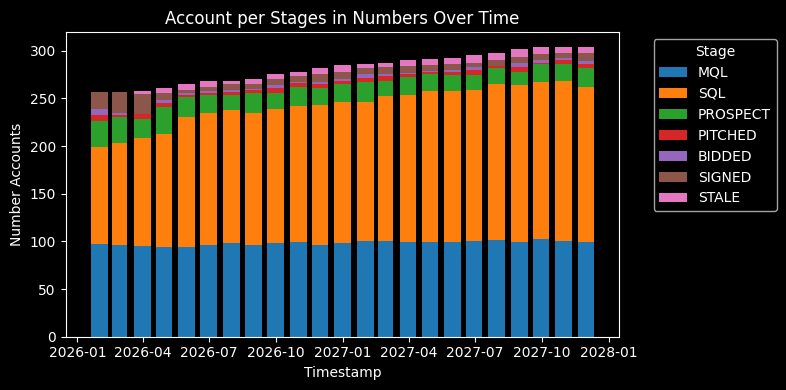

In [4]:
crm.plot_account_stats(as_share=False, hide_mql=False, hide_mql_sql=False)

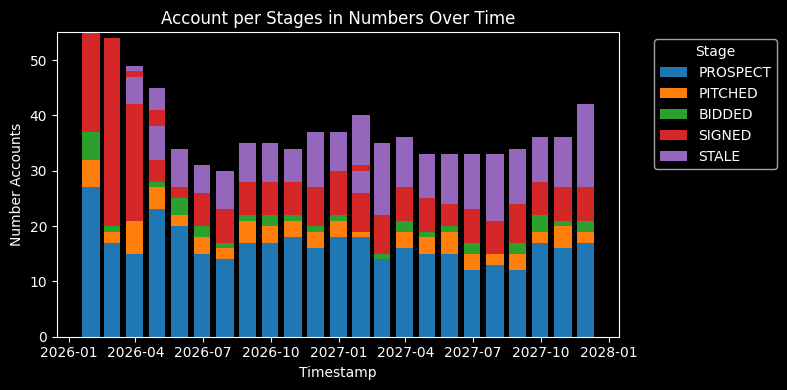

In [5]:
crm.plot_account_stats(as_share=False, hide_mql=True, hide_mql_sql=True)

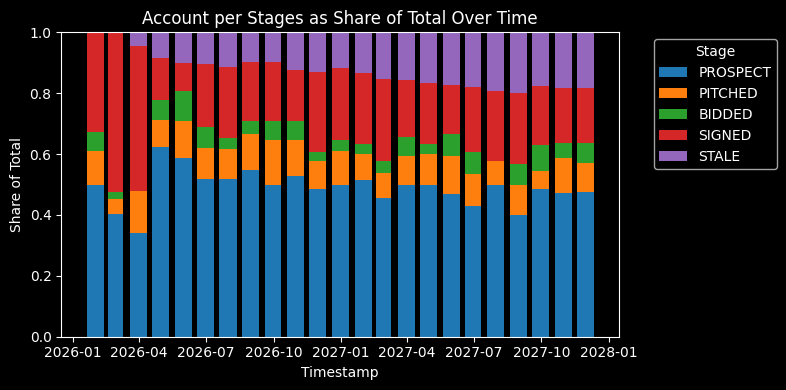

In [6]:
crm.plot_account_stats(as_share=True, hide_mql=True, hide_mql_sql=True)

In [7]:
df_stats.tail(3)

,nb_accounts,LEAD,MQL,SQL,PROSPECT,PITCHED,BIDDED,SIGNED,ACTIVE,STALE
timestamp,,,,,,,,,,
2027-11-15,304,0,99,167,20,6,2,4,0,6
2027-11-22,304,0,99,163,20,4,6,6,0,6
2027-11-29,304,0,99,163,21,4,2,9,0,6


In [8]:
ddff = crm.transactions_to_df()
ddff.intent.unique()
ddff.columns
# ddff.loc[ddff.loc[:, 'intent'] == 'opportunity', :]
# ddff.loc[ddff.loc[:, 'sender']=='acct-2a8f8ef1-1d85-4bea-9302-f300c58d4d1c'].loc[ddff.loc[:, 'value'].notna(), :]
dddfff = ddff.loc[ddff.loc[:, 'sender']=='acct-ff1da5a0-8221-4a2f-9811-ac001e8de203', :]
dddfff = ddff.loc[ddff.loc[:, 'intent'].isin(['purchase', 'opportunity']), :]
dddfff.loc[dddfff.loc[:,'value'].notna(), :].sort_values(by=['sender'])

,sender,receiver,intent,action,type,value
timestamp,,,,,,
2026-12-21,acct-02c0a2a8-f27c-46cd-9361-7ac8de60871b,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,opportunity,opportunity forecast,external,30000.0
2026-12-28,acct-02c0a2a8-f27c-46cd-9361-7ac8de60871b,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,purchase,purchase value,external,30000.0
2027-05-10,acct-038ac3a0-2bc4-4385-912d-f62aee5b9344,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,opportunity,opportunity forecast,external,45000.0
2027-10-25,acct-038ac3a0-2bc4-4385-912d-f62aee5b9344,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,opportunity,opportunity forecast,external,27000.0
2026-03-02,acct-038ac3a0-2bc4-4385-912d-f62aee5b9344,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,opportunity,opportunity forecast,external,30000.0
...,...,...,...,...,...,...
2027-01-04,acct-f7660bc3-ae1f-427f-b0b0-c69a7771dfa5,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,opportunity,opportunity forecast,external,122000.0
2026-09-07,acct-fb50bdd2-075d-4795-bc78-3eee5e4b8f74,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,opportunity,opportunity forecast,external,617000.0
2026-11-16,acct-fe627202-9664-4115-92e6-cc4977f88984,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,opportunity,opportunity forecast,external,236000.0


In [9]:
bizval = ddff.loc[ddff.loc[:, 'intent'].isin(['purchase', 'opportunity']), :]
opportunities = ddff.loc[ddff.loc[:, 'intent'].isin(['opportunity']), :]
purchases = ddff.loc[ddff.loc[:, 'intent'].isin(['purchase']), :]
bizval = bizval.sort_index().sort_values(by=['sender','timestamp'], ascending=True)
display(bizval.head())
display(opportunities.head())
display(purchases.head())
# bizval.loc[bizval.loc[:, 'sender']=='acct-03c631e1-3150-44b8-b97e-27aba24e9924']

,sender,receiver,intent,action,type,value
timestamp,,,,,,
2026-12-21,acct-02c0a2a8-f27c-46cd-9361-7ac8de60871b,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,opportunity,opportunity forecast,external,30000.0
2026-12-28,acct-02c0a2a8-f27c-46cd-9361-7ac8de60871b,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,purchase,purchase value,external,30000.0
2026-03-02,acct-038ac3a0-2bc4-4385-912d-f62aee5b9344,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,opportunity,opportunity forecast,external,30000.0
2027-05-10,acct-038ac3a0-2bc4-4385-912d-f62aee5b9344,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,opportunity,opportunity forecast,external,45000.0
2027-09-06,acct-038ac3a0-2bc4-4385-912d-f62aee5b9344,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,opportunity,opportunity forecast,external,12000.0


,sender,receiver,intent,action,type,value
timestamp,,,,,,
2026-01-05,acct-55b3b3e7-4c1c-42fd-8d8a-f5706503ab61,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,opportunity,opportunity forecast,external,24000.0
2026-01-05,acct-4822a956-22c0-47a0-914c-a15b7e0d8b20,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,opportunity,opportunity forecast,external,20000.0
2026-01-05,acct-62fc43ad-75f8-4dc3-ba59-25df40e8441b,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,opportunity,opportunity forecast,external,537000.0
2026-01-05,acct-e962f0ad-f313-40ee-9ab5-9ea193b23ca0,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,opportunity,opportunity forecast,external,283000.0
2026-01-05,acct-7bf015ae-d348-45f1-8c4e-fd0379483b4b,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,opportunity,opportunity forecast,external,211000.0


,sender,receiver,intent,action,type,value
timestamp,,,,,,
2026-01-05,acct-cab6f6ff-964b-4bc7-9a12-a9d66a00c556,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,purchase,purchase value,external,0.0
2026-01-05,acct-9b7897f2-0dee-45ec-a810-2bd54ca6fe88,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,purchase,purchase value,external,0.0
2026-01-05,acct-4b53fd42-1ab7-4b34-8b24-8fbbc5aff00b,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,purchase,purchase value,external,0.0
2026-01-05,acct-15d7aae9-b9cb-4d94-a3d8-e486604baa54,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,purchase,purchase value,external,0.0
2026-01-05,acct-619717ba-601b-4c38-97ab-0caa927ca34d,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,purchase,purchase value,external,0.0


In [10]:
opps_per_account = opportunities.groupby(by=['sender']).agg({ 'receiver':'last','intent': 'count', 'action': 'last', 'value':'sum'})
opps_per_account

,receiver,intent,action,value
sender,,,,
acct-02c0a2a8-f27c-46cd-9361-7ac8de60871b,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,1,opportunity forecast,30000.0
acct-038ac3a0-2bc4-4385-912d-f62aee5b9344,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,4,opportunity forecast,114000.0
acct-06402483-2a58-498c-b86c-33ea2747495c,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,1,opportunity forecast,659000.0
acct-08731eca-8ac2-46b3-bc8f-536a09b6b56f,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,1,opportunity forecast,58000.0
acct-0ce4dc47-48f7-405f-a023-31447b6184a3,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,1,opportunity forecast,706000.0
...,...,...,...,...
acct-ee6ad531-a5f7-4a31-931b-10fcbd3e7c68,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,1,opportunity forecast,151000.0
acct-f5bc6562-be8b-4929-938b-f4b629f42dfa,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,1,opportunity forecast,746000.0
acct-f7660bc3-ae1f-427f-b0b0-c69a7771dfa5,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,2,opportunity forecast,287000.0


In [11]:
pos_per_account = purchases.groupby(by=['sender']).agg({ 'receiver':'last','intent': 'count', 'action': 'last', 'value':'sum'})
pos_per_account

,receiver,intent,action,value
sender,,,,
acct-02c0a2a8-f27c-46cd-9361-7ac8de60871b,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,1,purchase value,30000.0
acct-0ce4dc47-48f7-405f-a023-31447b6184a3,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,1,purchase value,706000.0
acct-127ff5b6-a4bd-4661-8a23-6f03a792a3ca,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,1,purchase value,950000.0
acct-15d7aae9-b9cb-4d94-a3d8-e486604baa54,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,2,purchase value,500000.0
acct-192be3c1-dd1f-45af-ae95-2f2ba88a40d4,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,1,purchase value,56000.0
...,...,...,...,...
acct-de29054d-4722-4cb1-8975-577a7be6bee5,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,1,purchase value,219000.0
acct-e2e905d8-2311-48ef-87ac-ae83e3e27cc2,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,2,purchase value,1572000.0
acct-f5bc6562-be8b-4929-938b-f4b629f42dfa,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,1,purchase value,746000.0


In [12]:
business_per_account = pd.merge(left=opps_per_account.loc[:, ['intent', 'value']], right=pos_per_account.loc[:, ['intent', 'value']], how='left', left_index=True, right_index=True, suffixes=('_opp', '_po'))
business_per_account = pd.merge(left=business_per_account, right=crm.account_df().loc[:, ['name', 'account_type','industry', 'country', 'cumulative_opportunity_value', 'cumulative_purchase_value', 'nb_opportunities', 'nb_purchases', 'uid']], how='left', left_index=True, right_on='uid')
business_per_account.columns = '|'.join(business_per_account.columns).replace('intent_', 'nb_').split('|')
business_per_account['avg_opp'] = business_per_account['value_opp'] / business_per_account['nb_opp']
business_per_account['avg_po'] = business_per_account['value_po'].div(business_per_account['nb_po'])
business_per_account['success_rate_value'] = business_per_account['value_po']/business_per_account['value_opp']
business_per_account['success_rate_nb'] = business_per_account['nb_po']/business_per_account['nb_opp']
business_per_account = business_per_account.fillna(0)
business_per_account.head()

,nb_opp,value_opp,nb_po,value_po,name,account_type,industry,country,cumulative_opportunity_value,cumulative_purchase_value,nb_opportunities,nb_purchases,uid,avg_opp,avg_po,success_rate_value,success_rate_nb
123,1,30000.0,1.0,30000.0,"TianjinWrap Co., Ltd.",SMALL,FoodnBeverage,CN,30000,30000,1,0,acct-02c0a2a8-f27c-46cd-9361-7ac8de60871b,30000.0,30000.0,1.0,1.0
145,4,114000.0,0.0,0.0,SzczecinPak Sp. z o.o.,SMALL,Electronics,EU,114000,0,4,0,acct-038ac3a0-2bc4-4385-912d-f62aee5b9344,28500.0,0.0,0.0,0.0
170,1,659000.0,0.0,0.0,WorldPac Innovations Inc.,LARGE,Chemicals,US,659000,0,1,0,acct-06402483-2a58-498c-b86c-33ea2747495c,659000.0,0.0,0.0,0.0
225,1,58000.0,0.0,0.0,WuppertalPack GmbH,MEDIUM,IndustrialManufacturing,EU,58000,0,1,0,acct-08731eca-8ac2-46b3-bc8f-536a09b6b56f,58000.0,0.0,0.0,0.0
259,1,706000.0,1.0,706000.0,ArizonaPack LLC,LARGE,IndustrialManufacturing,US,706000,706000,1,0,acct-0ce4dc47-48f7-405f-a023-31447b6184a3,706000.0,706000.0,1.0,1.0


In [13]:
def plot_funnel_biz(df, title=None, figsize=(8, 3)):
    # reversed_cols = funnel.columns[::-1]
    fig,ax = plt.subplots(figsize=figsize)
    bars = df.T.plot(kind='barh', ax=ax, title=title or 'Conversion Rates')
    ax.invert_yaxis()
    # Add value labels to each bar
    max_val = df.max()
    ax.set_xlim(0, max_val * 1.15)  # Add 15% padding to the right
    for i, v in enumerate(df.values):
        ax.text(v + 0.01, i, f"{v:.2f}", va='center', ha='left',fontsize=10)
    plt.show()

In [14]:
business_per_account.groupby(by='account_type').agg({'success_rate_value':'mean','success_rate_nb':'mean','avg_opp':'mean','avg_po':'mean','value_opp':'sum','value_po':'sum','nb_opp':'sum','nb_po':'sum'})

,success_rate_value,success_rate_nb,avg_opp,avg_po,value_opp,value_po,nb_opp,nb_po
account_type,,,,,,,,
LARGE,0.416986,0.467105,694929.824561,383149.122807,40342000.0,18185000.0,59,28.0
MEDIUM,0.430134,0.443182,153875.000000,77814.393939,9617000.0,4380000.0,61,29.0
SMALL,0.276586,0.280093,28543.981481,9750.000000,1785000.0,424000.0,61,15.0


In [15]:
biz_per_ind = business_per_account.groupby(by='industry').agg({'success_rate_value':'mean','success_rate_nb':'mean','avg_opp':'mean','avg_po':'mean','value_opp':'sum','value_po':'sum','nb_opp':'sum','nb_po':'sum'})
biz_per_ind

,success_rate_value,success_rate_nb,avg_opp,avg_po,value_opp,value_po,nb_opp,nb_po
industry,,,,,,,,
AutomotiveParts,0.175367,0.180556,129666.666667,111277.777778,2875000.0,1943000.0,16,4.0
Chemicals,0.402472,0.452381,246166.666667,117761.904762,6303000.0,2650000.0,27,12.0
ConsumerGoods,0.200646,0.192982,398342.105263,189000.000000,12311000.0,3591000.0,27,6.0
Electronics,0.363750,0.388889,260077.777778,93600.000000,5517000.0,1499000.0,25,8.0
FoodnBeverage,0.464370,0.465278,314548.611111,171402.777778,6238000.0,3372000.0,21,11.0
IndustrialManufacturing,0.643385,0.657407,304990.740741,277166.666667,8386000.0,5711000.0,29,18.0
PackagingSI,0.416667,0.416667,299000.000000,149500.000000,4408000.0,2614000.0,14,7.0
Pharmaceuticals,0.253497,0.322222,262388.888889,90600.000000,5706000.0,1609000.0,22,6.0


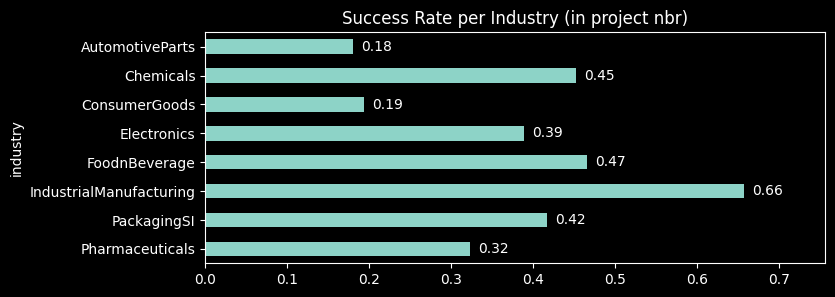

In [16]:
plot_funnel_biz(biz_per_ind.loc[:,'success_rate_nb'], title= f"Success Rate per Industry (in project nbr)")

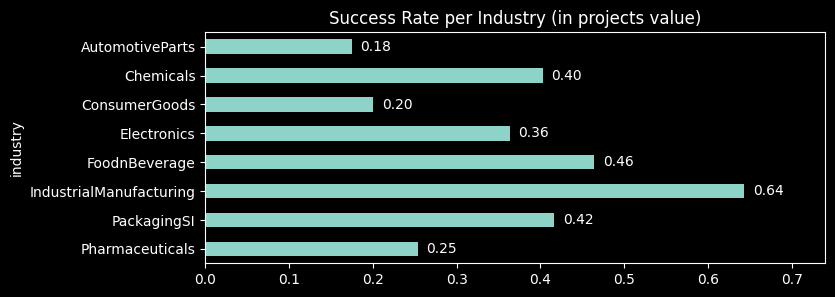

In [17]:
plot_funnel_biz(biz_per_ind.loc[:,'success_rate_value'], title= f"Success Rate per Industry (in projects value)")

In [18]:
biz_per_country = business_per_account.groupby(by='country').agg({'success_rate_value':'mean','success_rate_nb':'mean','avg_opp':'mean','avg_po':'mean','value_opp':'sum','value_po':'sum','nb_opp':'sum','nb_po':'sum'})
biz_per_country

,success_rate_value,success_rate_nb,avg_opp,avg_po,value_opp,value_po,nb_opp,nb_po
country,,,,,,,,
CN,0.309769,0.355072,361855.072464,170086.956522,12605000.0,5347000.0,32,12.0
EU,0.355379,0.382514,253178.961749,122527.322404,23476000.0,9906000.0,97,35.0
US,0.468402,0.465686,307024.509804,204362.745098,15663000.0,7736000.0,52,25.0


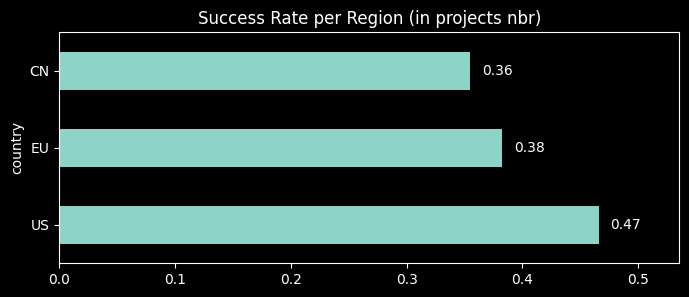

In [19]:
plot_funnel_biz(biz_per_country.loc[:,'success_rate_nb'], title= f"Success Rate per Region (in projects nbr)")

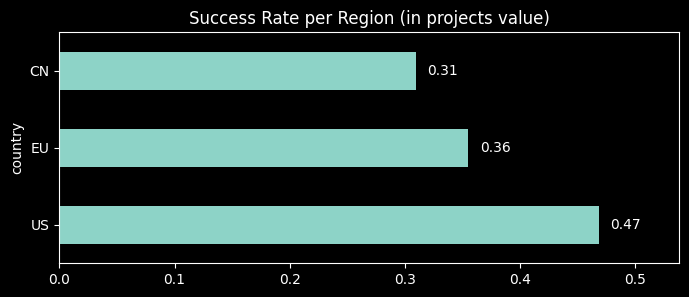

In [20]:
plot_funnel_biz(biz_per_country.loc[:,'success_rate_value'], title= f"Success Rate per Region (in projects value)")

In [21]:
biz_per_type = business_per_account.groupby(by='account_type').agg({'success_rate_value':'mean','success_rate_nb':'mean','avg_opp':'mean','avg_po':'mean','value_opp':'sum','value_po':'sum','nb_opp':'sum','nb_po':'sum'})
biz_per_type

,success_rate_value,success_rate_nb,avg_opp,avg_po,value_opp,value_po,nb_opp,nb_po
account_type,,,,,,,,
LARGE,0.416986,0.467105,694929.824561,383149.122807,40342000.0,18185000.0,59,28.0
MEDIUM,0.430134,0.443182,153875.000000,77814.393939,9617000.0,4380000.0,61,29.0
SMALL,0.276586,0.280093,28543.981481,9750.000000,1785000.0,424000.0,61,15.0


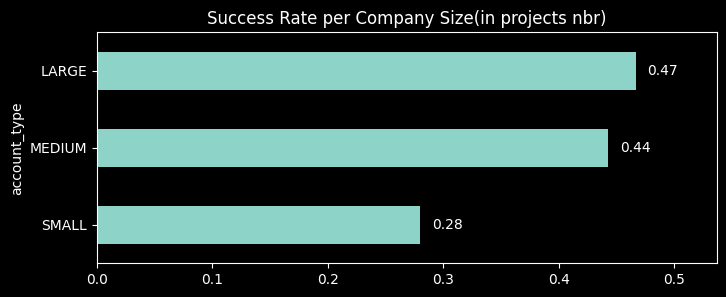

In [22]:
plot_funnel_biz(biz_per_type.loc[:,'success_rate_nb'], title= f"Success Rate per Company Size(in projects nbr)")

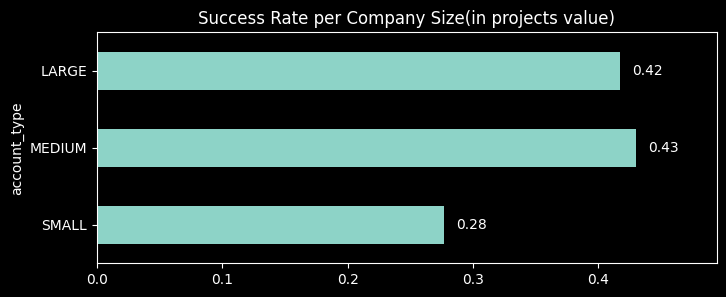

In [23]:
plot_funnel_biz(biz_per_type.loc[:,'success_rate_value'], title= f"Success Rate per Company Size(in projects value)")

### Funnel Analysis

In [24]:
df = crm.transactions_to_df()
df.loc[df.action == 'transition',:].intent.unique()

array(['SQL to PROSPECT', 'SQL to SQL', 'PITCHED to BIDDED',
       'PITCHED to SQL', 'BIDDED to SIGNED', 'BIDDED to SQL',
       'MQL to SQL', 'PROSPECT to PITCHED', 'PROSPECT to SQL',
       'SIGNED to STALE', 'SIGNED to PROSPECT'], dtype=object)

In [25]:
coi = [
    # 'MQL to SQL',
    'SQL to PROSPECT', 
    'SQL to SQL', 
    'PROSPECT to PITCHED', 
    'PROSPECT to SQL', 
    'PITCHED to BIDDED', 
    'PITCHED to SQL',
    'BIDDED to SIGNED',
    'BIDDED to SQL',
    'SIGNED to PROSPECT', 
    'SIGNED to STALE'
       ]
coi_success = [
    # 'MQL to SQL',
    'SQL to PROSPECT', 
    'PROSPECT to PITCHED', 
    'PITCHED to BIDDED', 
    'BIDDED to SIGNED',
    'SIGNED to PROSPECT', 
       ]
coi_fail = [
    # 'MQL to SQL',
    'SQL to SQL', 
    'PROSPECT to SQL', 
    'PITCHED to SQL',
    'BIDDED to SQL',
    'SIGNED to STALE'
       ]
funnel_trans = df.loc[df.action == 'transition',:]

In [26]:
funnel_trans.groupby('intent').count()

,sender,receiver,action,type,value
intent,,,,,
BIDDED to SIGNED,152,152,152,152,0
BIDDED to SQL,228,228,228,228,0
MQL to SQL,53,53,53,53,0
PITCHED to BIDDED,362,362,362,362,0
PITCHED to SQL,278,278,278,278,0
PROSPECT to PITCHED,622,622,622,622,0
PROSPECT to SQL,584,584,584,584,0
SIGNED to PROSPECT,138,138,138,138,0
SIGNED to STALE,12,12,12,12,0


In [27]:
cois = {
    # 'MQL to SQL': 'MQL',
    'SQL to PROSPECT': 'SQL',
    'PROSPECT to PITCHED': 'PROSPECT',
    'PITCHED to BIDDED': 'PITCHED',
    'BIDDED to SIGNED': 'BIDDED',
    'SIGNED to PROSPECT': 'SIGNED',
}

list(map(lambda x: cois[x], ['SQL to PROSPECT', 'PROSPECT to PITCHED', 'PITCHED to BIDDED', 'BIDDED to SIGNED', 'SIGNED to PROSPECT']))

['SQL', 'PROSPECT', 'PITCHED', 'BIDDED', 'SIGNED']

In [28]:
def build_funnel(df):
    coi_success = {
        # 'MQL to SQL': 'MQL',
        'SQL to PROSPECT': 'SQL',
        'PROSPECT to PITCHED': 'PROSPECT',
        'PITCHED to BIDDED': 'PITCHED',
        'BIDDED to SIGNED': 'BIDDED',
        'SIGNED to PROSPECT': 'SIGNED',
    }
    coi_fail = {
        # 'MQL to SQL': 'MQL,
        'SQL to SQL': 'SQL',
        'PROSPECT to SQL': 'PROSPECT',
        'PITCHED to SQL': 'PITCHED',
        'BIDDED to SQL': 'BIDDED',
        'SIGNED to STALE': 'SIGNED',
    }
    def _funnel(df, cois, coif, aggfn:str):
        t_success = df.groupby(by='intent').agg(aggfn).T
        cols = [k for k, v in cois.items() if k in t_success.columns]
        t_success = t_success.loc[['action'],cols]
        cols = list(map(lambda x: cois[x], list(t_success.columns)))
        t_success.columns = cols
        t_fail = df.groupby(by='intent').agg(aggfn).T
        cols = [k for k, v in coif.items() if k in t_fail.columns]
        t_fail = t_fail.loc[['action'],cols]
        cols = list(map(lambda x: coif[x], list(t_fail.columns)))
        t_fail.columns = cols
        funnel = pd.concat([t_success, t_fail], axis=0)
        funnel.index = ['success', 'failed'] #type: ignore
        funnel.loc['total', :] = funnel.sum()
        return funnel
    
    funnels = {}
    if isinstance(df.index, pd.MultiIndex):
        for idx in list(set([idx[0] for idx in df.index])):
            funnels[idx] = _funnel(df.loc[(idx,),:], coi_success, coi_fail, 'sum')
    else:
        funnels['all'] = _funnel(df, coi_success, coi_fail, 'sum')
    return funnels

In [29]:
funnel_dict = build_funnel(funnel_trans.groupby('intent').count())
funnel_dict['all']

,SQL,PROSPECT,PITCHED,BIDDED,SIGNED
success,1070.0,622.0,362.0,152.0,138.0
failed,530.0,584.0,278.0,228.0,12.0
total,1600.0,1206.0,640.0,380.0,150.0


In [30]:
def plot_funnel(funnel, title=None, figsize=(8, 3)):
    # reversed_cols = funnel.columns[::-1]
    fig,ax = plt.subplots(figsize=figsize)
    df = funnel.loc['total', :] / funnel.loc['total','SQL']
    bars = df.clip(upper=1).T.plot(kind='barh', ax=ax, title=title or 'Conversion Rates')
    ax.invert_yaxis()
    # Add value labels to each bar
    max_val = df.max()
    ax.set_xlim(0, max_val * 1.15)  # Add 15% padding to the right
    for i, v in enumerate(df.values):
        ax.text(v + 0.01, i, f"{v:.2f}", va='center', ha='left',fontsize=10)
    plt.show()

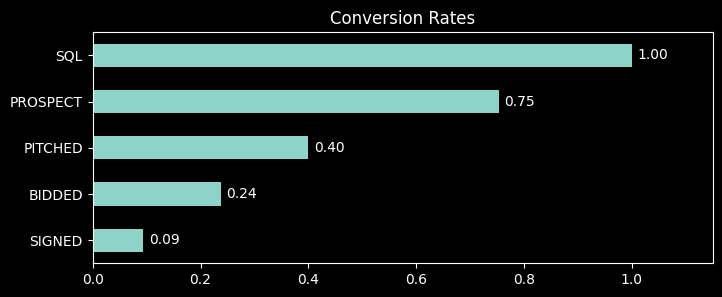

In [31]:
plot_funnel(funnel_dict['all'])

In [32]:
wkly_avg = funnel_dict['all'] / nb_weeks
print('Weekly Average:')
wkly_avg

Weekly Average:


,SQL,PROSPECT,PITCHED,BIDDED,SIGNED
success,10.918367,6.346939,3.693878,1.551020,1.408163
failed,5.408163,5.959184,2.836735,2.326531,0.122449
total,16.326531,12.306122,6.530612,3.877551,1.530612


### Build Detailed Dataset

In [33]:
funnel_uid = funnel_trans.receiver.unique()
print(len(funnel_uid), 'accounts in the funnel')
print(' | '.join(funnel_uid[:3]))
funnel_trans.tail(3)

206 accounts in the funnel
acct-426e3c62-9134-45fe-874a-932ff6396d74 | acct-a1d02c51-0954-4b53-8da5-22d0662ac0b3 | acct-71b8f67e-cd1d-48f2-bef9-c5c04d8cfd64


,sender,receiver,intent,action,type,value
timestamp,,,,,,
2027-12-01 02:24:00,crm-a70167f4-ad42-4f83-bbeb-295fb70065fc,acct-49164106-186d-494e-b0ee-1fa0b415fc38,SQL to PROSPECT,transition,system,NaN
2027-12-01 02:24:00,srep-612ce86c-3c04-4b96-bb57-c2d11e05bd59,acct-49164106-186d-494e-b0ee-1fa0b415fc38,SQL to PROSPECT,transition,internal,NaN
2027-12-05 07:12:00,crm-a70167f4-ad42-4f83-bbeb-295fb70065fc,acct-72bd92f1-be40-4606-8e56-3f9606282a31,MQL to SQL,transition,system,NaN


In [34]:
acct_ds = crm.account_df()
acct_uid = acct_ds['uid'].unique()
print(len(acct_uid), 'accounts in the crm record')
print((' | '.join(acct_uid[:3])))
acct_ds.tail(3)

304 accounts in the crm record
acct-7a48e718-7ddf-4dc6-9ae5-be8f8b121240 | acct-2af9d30d-721d-4f81-b375-26b78ffa2e8c | acct-6243bf91-5a62-4f47-881f-6106c414da6a


,account_type,assigned_salesrep,country,cumulative_opportunity_value,cumulative_purchase_value,industry,lead_source,name,nb_opportunities,nb_purchases,stage,uid
301,SMALL,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,CN,0,0,Pharmaceuticals,WEBSITE_CTA,ReginaWrap Inc.,0,0,MQL,acct-d923a134-decc-48ed-b86a-f078419d5c39
302,LARGE,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,CN,0,0,FoodnBeverage,SALES_REP,MuPack Ltd.,0,0,MQL,acct-d2f9c98e-c94f-4925-a4f3-2807928d30d4
303,MEDIUM,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,CN,0,0,ConsumerGoods,WEBSITE_CTA,"YunchengFlex Co., Ltd.",0,0,MQL,acct-886a4b8b-0423-4480-a910-62cdec25e5e5


In [35]:
srep_ds = crm.salesrep_df()
srep_uid = srep_ds.uid.unique()
print(len(srep_ds), 'sales reps in the crm record')
print((' | '.join(srep_uid[:3])))
srep_ds.tail(3)

4 sales reps in the crm record
srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85 | srep-014fb108-5820-4a78-b0f5-eae64856afa8 | srep-94280f37-ad99-47aa-8983-1de9feb69d34


,name,uid
1,SalesRep 2,srep-014fb108-5820-4a78-b0f5-eae64856afa8
2,SalesRep 3,srep-94280f37-ad99-47aa-8983-1de9feb69d34
3,SalesRep 4,srep-612ce86c-3c04-4b96-bb57-c2d11e05bd59


In [36]:
print(f"{len(set(acct_uid).intersection(set(funnel_uid))):,d} accounts in the funnel")
# print(f"{len(set(srep_uid).intersection(set(funnel_uid))):,d} accounts in the funnel")

206 accounts in the funnel


In [37]:
funnel_ds = pd.merge(left=funnel_trans, right=acct_ds, how='left', left_on='receiver', right_on='uid')
print(funnel_ds.shape)
print(funnel_ds.uid.unique().shape)
funnel_ds.head(3)

(4029, 18)
(206,)


,sender,receiver,intent,action,type,value,account_type,assigned_salesrep,country,cumulative_opportunity_value,cumulative_purchase_value,industry,lead_source,name,nb_opportunities,nb_purchases,stage,uid
0,crm-a70167f4-ad42-4f83-bbeb-295fb70065fc,acct-426e3c62-9134-45fe-874a-932ff6396d74,SQL to PROSPECT,transition,system,NaN,SMALL,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,EU,10000,0,Chemicals,EMAIL_CAMPAIGN,BristolPack Ltd.,1,0,SQL,acct-426e3c62-9134-45fe-874a-932ff6396d74
1,srep-94280f37-ad99-47aa-8983-1de9feb69d34,acct-426e3c62-9134-45fe-874a-932ff6396d74,SQL to PROSPECT,transition,internal,NaN,SMALL,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,EU,10000,0,Chemicals,EMAIL_CAMPAIGN,BristolPack Ltd.,1,0,SQL,acct-426e3c62-9134-45fe-874a-932ff6396d74
2,crm-a70167f4-ad42-4f83-bbeb-295fb70065fc,acct-a1d02c51-0954-4b53-8da5-22d0662ac0b3,SQL to PROSPECT,transition,system,NaN,MEDIUM,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,US,360000,0,Pharmaceuticals,SALES_REP,QuantumPack Inc.,2,0,SQL,acct-a1d02c51-0954-4b53-8da5-22d0662ac0b3


In [38]:
funnel_per_type = funnel_ds.groupby(by=['account_type', 'intent']).count().loc[:, ['action']]
funnel_per_type

action
account_type intent                     
LARGE        BIDDED to SIGNED         60
             BIDDED to SQL            64
             MQL to SQL               21
             PITCHED to BIDDED       118
             PITCHED to SQL           70
             PROSPECT to PITCHED     188
             PROSPECT to SQL         208
             SIGNED to PROSPECT       54
             SIGNED to STALE           4
             SQL to PROSPECT         352
             SQL to SQL              178
MEDIUM       BIDDED to SIGNED         62
             BIDDED to SQL            70
             MQL to SQL               18
             PITCHED to BIDDED       122
             PITCHED to SQL          112
             PROSPECT to PITCHED     222
             PROSPECT to SQL         216
             SIGNED to PROSPECT       56
             SIGNED to STALE           6
             SQL to PROSPECT         388
             SQL to SQL              218
SMALL        BIDDED to SIGNED         30
             BIDDED to SQL            94
             MQL to SQL               14
             PITCHED to BIDDED       122
             PITCHED to SQL           96
             PROSPECT to PITCHED     212
             PROSPECT to SQL         160
             SIGNED to PROSPECT       28
             SIGNED to STALE           2
             SQL to PROSPECT         330
             SQL to SQL              134

,SQL,PROSPECT,PITCHED,BIDDED,SIGNED
success,352.0,188.0,118.0,60.0,54.0
failed,178.0,208.0,70.0,64.0,4.0
total,530.0,396.0,188.0,124.0,58.0


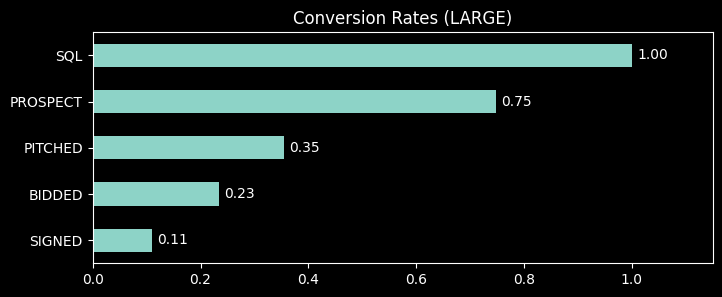

,SQL,PROSPECT,PITCHED,BIDDED,SIGNED
success,330.0,212.0,122.0,30.0,28.0
failed,134.0,160.0,96.0,94.0,2.0
total,464.0,372.0,218.0,124.0,30.0


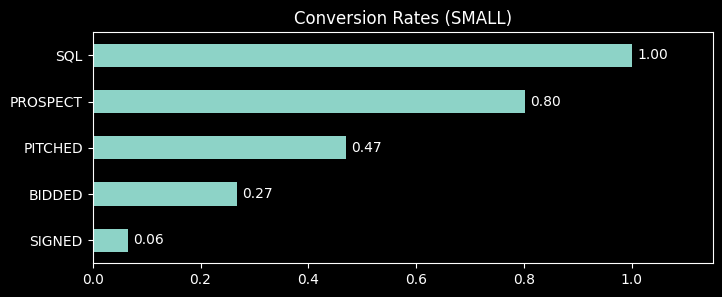

,SQL,PROSPECT,PITCHED,BIDDED,SIGNED
success,388.0,222.0,122.0,62.0,56.0
failed,218.0,216.0,112.0,70.0,6.0
total,606.0,438.0,234.0,132.0,62.0


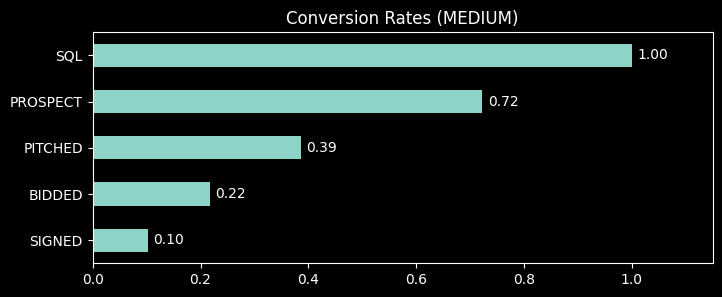

In [39]:
funnel_dict_per_type = build_funnel(funnel_per_type)
for k,v in funnel_dict_per_type.items():
    display(v)
    plot_funnel(v, title=f"Conversion Rates ({k})",figsize=(8, 3))

In [40]:
funnel_ds.head(3)

,sender,receiver,intent,action,type,value,account_type,assigned_salesrep,country,cumulative_opportunity_value,cumulative_purchase_value,industry,lead_source,name,nb_opportunities,nb_purchases,stage,uid
0,crm-a70167f4-ad42-4f83-bbeb-295fb70065fc,acct-426e3c62-9134-45fe-874a-932ff6396d74,SQL to PROSPECT,transition,system,NaN,SMALL,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,EU,10000,0,Chemicals,EMAIL_CAMPAIGN,BristolPack Ltd.,1,0,SQL,acct-426e3c62-9134-45fe-874a-932ff6396d74
1,srep-94280f37-ad99-47aa-8983-1de9feb69d34,acct-426e3c62-9134-45fe-874a-932ff6396d74,SQL to PROSPECT,transition,internal,NaN,SMALL,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,EU,10000,0,Chemicals,EMAIL_CAMPAIGN,BristolPack Ltd.,1,0,SQL,acct-426e3c62-9134-45fe-874a-932ff6396d74
2,crm-a70167f4-ad42-4f83-bbeb-295fb70065fc,acct-a1d02c51-0954-4b53-8da5-22d0662ac0b3,SQL to PROSPECT,transition,system,NaN,MEDIUM,srep-4dc41547-3a6b-4da6-97fd-45e6fb3b3c85,US,360000,0,Pharmaceuticals,SALES_REP,QuantumPack Inc.,2,0,SQL,acct-a1d02c51-0954-4b53-8da5-22d0662ac0b3


In [41]:
funnel_per_country = funnel_ds.groupby(by=['country', 'intent']).count().loc[:, ['action']]
funnel_per_country

action
country intent                     
CN      BIDDED to SIGNED         30
        BIDDED to SQL            42
        MQL to SQL               13
        PITCHED to BIDDED        64
        PITCHED to SQL           48
        PROSPECT to PITCHED     104
        PROSPECT to SQL         188
        SIGNED to PROSPECT       32
        SIGNED to STALE           2
        SQL to PROSPECT         260
        SQL to SQL              246
EU      BIDDED to SIGNED         72
        BIDDED to SQL           130
        MQL to SQL               21
        PITCHED to BIDDED       194
        PITCHED to SQL          178
        PROSPECT to PITCHED     366
        PROSPECT to SQL         238
        SIGNED to PROSPECT       62
        SIGNED to STALE           6
        SQL to PROSPECT         536
        SQL to SQL              120
US      BIDDED to SIGNED         50
        BIDDED to SQL            56
        MQL to SQL               19
        PITCHED to BIDDED       104
        PITCHED to SQL           52
        PROSPECT to PITCHED     152
        PROSPECT to SQL         158
        SIGNED to PROSPECT       44
        SIGNED to STALE           4
        SQL to PROSPECT         274
        SQL to SQL              164

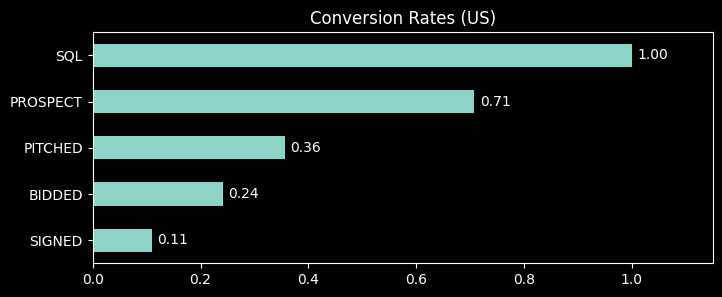

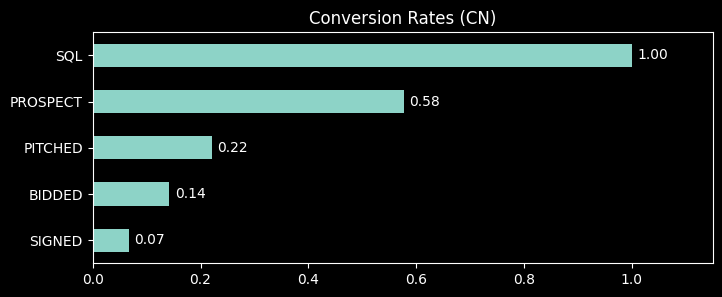

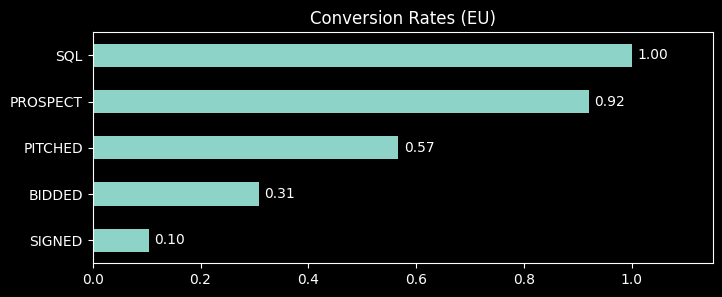

In [42]:
funnel_dict_per_country = build_funnel(funnel_per_country)
for k,v in funnel_dict_per_country.items():
    plot_funnel(v, title=f"Conversion Rates ({k})",figsize=(8, 3))

In [43]:
funnel_per_ind = funnel_ds.groupby(by=['industry', 'intent']).count().loc[:, ['action']]
funnel_per_ind

action
industry        intent                    
AutomotiveParts BIDDED to SIGNED         8
                BIDDED to SQL           22
                MQL to SQL               1
                PITCHED to BIDDED       32
                PITCHED to SQL           6
...                                    ...
Pharmaceuticals PROSPECT to SQL         78
                SIGNED to PROSPECT      10
                SIGNED to STALE          2
                SQL to PROSPECT        138
                SQL to SQL             102

[84 rows x 1 columns]

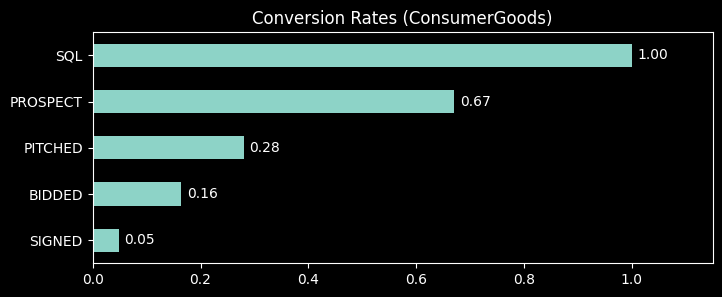

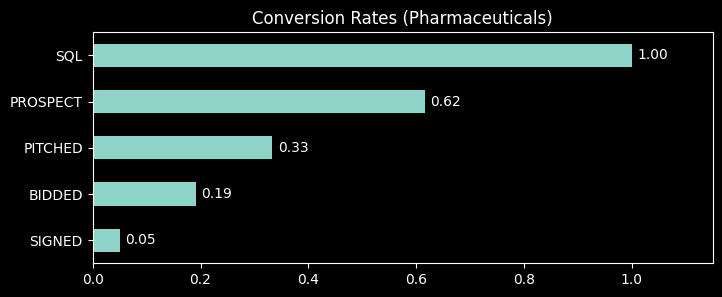

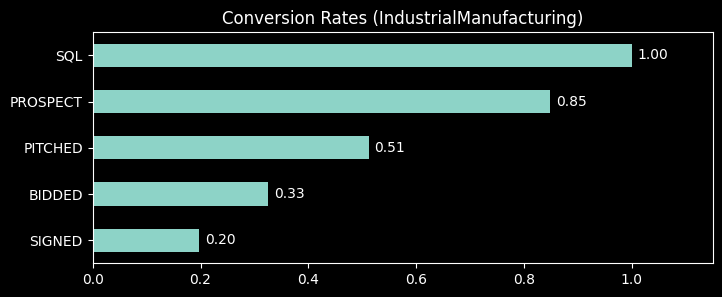

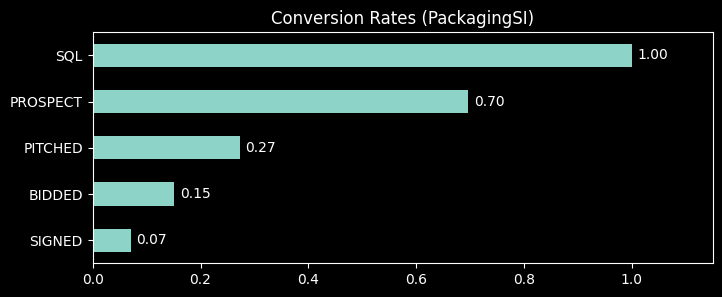

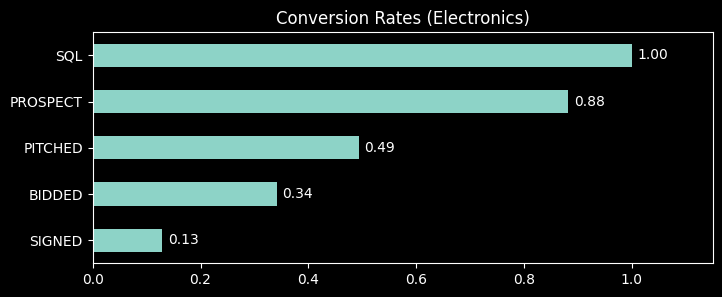

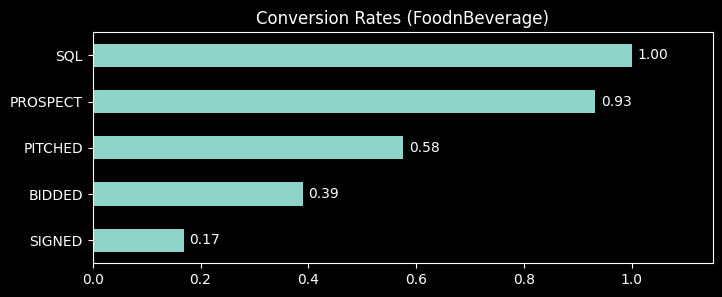

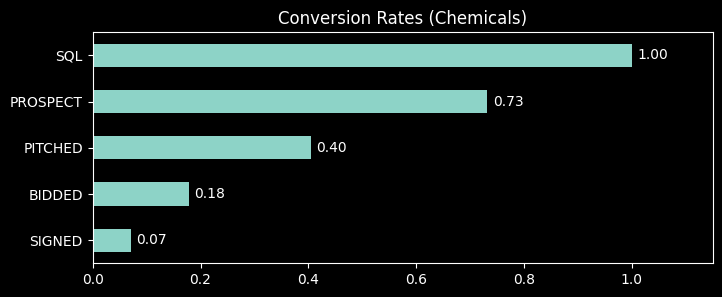

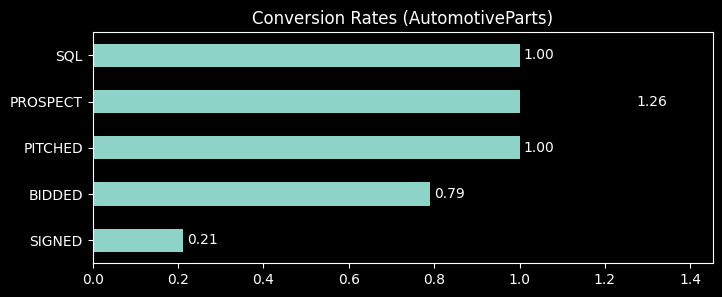

In [44]:
funnel_dict_per_ind = build_funnel(funnel_per_ind)
for k,v in funnel_dict_per_ind.items():
    plot_funnel(v, title=f"Conversion Rates ({k})",figsize=(8, 3))

#### Reference Conversion Rates

##### MQL
- website
    - nb mthly website visitor=2900 monthly
    - website cta rate=0.03
- email
    - online campaigns targets=1000 monthly
    - online campaigns clickthru=0.1
- industry event
    - nb industry events=1 quarterly
    - rawleads industry events=80 * nb industry events
- direct calls
    - rawleads salesreps=30 monthly (?)
- conversion 
    - rawlead2mql website=0.41
    - rawlead2mql online campaign=0.38
    - rawlead2mql industry event=0.3
    - salesrep leads2mql=0.02

##### SQL and later stages
- conversion
    - mql2sql=0.15
    - sql2prospect=0.7
    - prospect2prez=0.7
    - prez2bid=0.6
    - bid2close=0.3
    - customer satisfaction rate=0.98

- delays
    - mql2sql= 1 to 2 weeks
    - sql2prospect= 1 to 2 weeks
    - prospect2prez= 1 to 4 weeks
    - prez2bid= 2 to 12 weeks
    - bid2close= 2 to 12 weeks
    - customer project duration = 12 to 24 weeks


- decay rate=0.15

In [45]:
crm = CustomerRelationManagerSimulator()
crm.populate(nb_salesreps=3, nb_mql=10, nb_sql=0, nb_others=0)
with open(p2log, 'w') as f:
    f.write(f"CRM simulation started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"CRM UID: {crm.uid}\n")
    f.write(f"CRM Name: {crm.name}\n")
    f.write(f"{'='* 100}")

crm.run(until=100)

Created 10 MQL accounts
Total accounts created: 10


In [46]:
df = crm.transactions_to_df()
df.loc[df.type != 'system', :]
df.loc[df.action == 'accept', :]
df.tail()

,sender,receiver,intent,action,type,value
timestamp,,,,,,
2027-12-05 07:12:00,acct-63b8c354-700c-4187-b318-2b76d498667b,mktg-08bc7d86-bfbf-4e84-b17a-6aafc215170b,email campaign,reject,external,NaN
2027-12-05 07:12:00,acct-a5ca8b9b-8785-4d10-b74e-4a7ff4649fa3,mktg-08bc7d86-bfbf-4e84-b17a-6aafc215170b,email campaign,reject,external,NaN
2027-12-05 07:12:00,acct-644bbe86-a14a-49a5-b539-25eb6156e01a,mktg-08bc7d86-bfbf-4e84-b17a-6aafc215170b,email campaign,reject,external,NaN
2027-12-05 07:12:00,crm-7ccec378-94bc-423e-9c10-6d81f8426f2a,acct-0913eebf-665a-4ef3-8e13-cf5a53c2ce59,MQL to SQL,transition,system,NaN
2027-12-05 07:12:00,srep-b12d684a-64ce-4c65-8cf1-1f7bc4606818,acct-0913eebf-665a-4ef3-8e13-cf5a53c2ce59,assign sales rep,assign,system,NaN


In [47]:
crm.account_stats_to_df(int_idx=True)

,timestamp,nb_accounts,LEAD,MQL,SQL,PROSPECT,PITCHED,BIDDED,SIGNED,ACTIVE,STALE
0,1,10,0,9,1,0,0,0,0,0,0
1,2,10,0,9,0,1,0,0,0,0,0
2,3,10,0,9,0,1,0,0,0,0,0
3,4,10,0,8,1,1,0,0,0,0,0
4,5,10,0,8,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
94,95,62,0,17,25,9,3,1,4,0,3
95,96,62,0,17,26,9,0,2,5,0,3
96,97,62,0,17,22,13,1,0,6,0,3
97,98,62,0,17,20,15,2,0,5,0,3


# Sandbox

### Check the countries represented in the data

In [48]:
p2data = Path('../data/account-info-clean.tsv').resolve()
assert p2data.is_file(), p2data

In [49]:
df = pd.read_csv(p2data, sep='\t')
display(df.head())
# df.Country = df.Country.str.split('.').apply(lambda x: x[1].strip())
df.sample(10)

,Country,Company Name,Industry
0,EU,EuroPac GmbH,FoodnBeverage
1,EU,Alpine Packaging S.A.,ConsumerGoods
2,EU,PackItalia S.p.A.,Pharmaceuticals
3,EU,DutchFlex BV,IndustrialManufacturing
4,EU,Belgipack NV,Chemicals


,Country,Company Name,Industry
368,EU,BrugesFlex NV,Chemicals
880,EU,CellePack GmbH,Chemicals
904,EU,OffenburgPack GmbH,ConsumerGoods
401,CN,PahangPack Industries,PackagingSI
234,CN,HamiltonWrap Inc.,Pharmaceuticals
360,CN,OttawaFlex Inc.,Pharmaceuticals
1046,CN,ShenzhenFlex Ltd.,Pharmaceuticals
1111,EU,WürzburgFlex GmbH,Chemicals
6,EU,CzechoWrap s.r.o.,AutomotiveParts
921,US,LibertyPac Inc.,IndustrialManufacturing


In [50]:
# df.to_csv(p2data, sep='\t', index=False)

In [51]:
from utils import account_info_generator #type: ignore

In [52]:
cgen = account_info_generator()

In [53]:
next(cgen)  

Country                      CN
Company Name    QuebecWrap Inc.
Industry        Pharmaceuticals
Name: 0, dtype: object